In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns 
import plotly.graph_objects as go
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report, confusion_matrix,ConfusionMatrixDisplay
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer 
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.cm as cm
from matplotlib import rcParams
from collections import Counter
from nltk.tokenize import RegexpTokenizer
import re
import string
from tensorflow.keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
%matplotlib inline
import nltk
nltk.download('punkt')
import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/zhuxiaojun/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Firstly, we use one-dimensional convolution, the so-called one-dimensional convolution is the convolution of window size * embedding dimension. window size is actually the number of words, if the window size is equal to 2, it means each time to select two words If the window size is equal to 3, it means each time to select three words. If the window size is equal to 3. The point of this convolution is to get one n-gram feature at a time, which is similar to our intuition. The convolution is followed by max-1-pooling, which means that the most salient words or phrases in the sentence are selected as the result of the next layer. These keywords are then combined and fed into the fully connected layer to get the classification result.

Next, the CNN model of conv1D + max-pooling is created. First, initialize an embedding and randomize a word vector for all the words (here you can also use pre-trained word vectors for better results). Then use Conv1D for convolution, where the parameter kernel_size is the window size we mentioned earlier, here we make it equal to 3, that is, we take 3 words at a time, and get tri-gram features. Then GlobalMaxPooling for pooling, and finally use the fully connected layer to get a value. This value represents the score that belongs to which category. The optimization is done using Adam optimizer.

In [2]:
import numpy as np 
import pandas as pd 
import seaborn as sns 
import plotly.graph_objects as go
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report, confusion_matrix,ConfusionMatrixDisplay
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer 
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.cm as cm
from matplotlib import rcParams
from collections import Counter
from nltk.tokenize import RegexpTokenizer
from keras.models import Model
from keras.layers import Input, Embedding, Conv1D, MaxPooling1D, Flatten, concatenate, Dense, Dropout
from keras.preprocessing import sequence
from tensorflow.keras.utils import plot_model

import re
import string
from tensorflow.keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from keras.preprocessing.sequence import pad_sequences
%matplotlib inline
import nltk
nltk.download('punkt')
import warnings
warnings.filterwarnings("ignore")
def load_dataset(filename):
    data = pd.read_csv(filename, encoding='ISO-8859-1')
    data.columns = ["label", "time", "date", "query", "username", "text"]
    data = data.loc[:, ['text', 'label']]
    data['label'][data['label'] == 4] = 1
#     trainLines = data['text']  # Use all data points for trainLines
#     trainLabels = data['label']  # Use all data points for trainLabels
#     trainLines = data[data['label'] == 1]['text']
#     trainLabels = data[data['label'] == 0]['label']
    data_pos = data[data['label'] == 1]
    data_neg = data[data['label'] == 0]
    data_pos = data_pos.iloc[:int(20000)]
    data_neg = data_neg.iloc[:int(20000)]
    data = pd.concat([data_pos, data_neg])
    trainLines = data['text']
    trainLabels = data['label']
    return trainLines, trainLabels
trainLines, trainLabels = load_dataset('training.1600000.processed.noemoticon.csv')



def cleaning_stopwords(text):
    cleaned_words = []
    nltk.download('stopwords')
    stopwords_list = stopwords.words('english')
    ", ".join(stopwords.words('english'))
    STOPWORDS = set(stopwords.words('english'))
    words = str(text).split()
    for word in words:
        if word not in STOPWORDS:
            cleaned_words.append(word)
    cleaned_text = " ".join(cleaned_words)
    
    return cleaned_text
trainLines = trainLines.apply(cleaning_stopwords)

def cleaning_URLs(data):
    words = data.split()
    cleaned_words = [word for word in words if not (word.startswith("www.") or word.startswith("http://") or word.startswith("https://"))]
    cleaned_data = " ".join(cleaned_words)
    
    return cleaned_data
trainLines = trainLines.apply(cleaning_URLs)
punctuations_list = string.punctuation

def cleaning_punctuations(text):
    cleaned_words = []
    words = text.split()
    for word in words:
        cleaned_word = ''.join(char for char in word if char not in punctuations_list)
        cleaned_words.append(cleaned_word)
    cleaned_text = " ".join(cleaned_words)
    return cleaned_text

# Example usage:
trainLines = trainLines.apply(cleaning_punctuations)

def cleaning_repeating_char(text):
    cleaned_text = ''
    prev_char = None
    for char in text:
        if char != prev_char:
            cleaned_text += char
        prev_char = char
    return cleaned_text
trainLines  = trainLines.apply(cleaning_repeating_char)

def cleaning_email(data):
    words = data.split()
    cleaned_words = [word for word in words if "@" not in word]
    cleaned_data = " ".join(cleaned_words)
    return cleaned_data
trainLines= trainLines.apply(cleaning_email)

def cleaning_numbers(text):
    cleaned_words = ["".join(char for char in word if not char.isdigit()) for word in text.split()]
    cleaned_words = [word for word in cleaned_words if word]
    cleaned_data = " ".join(cleaned_words)
    return cleaned_data

trainLines = trainLines.apply(cleaning_numbers)

st = nltk.PorterStemmer()
def stemming_on_text(data):
    text = [st.stem(word) for word in data]
    return data

trainLines= trainLines.apply(lambda x: stemming_on_text(x))


nltk.download('wordnet')

nltk.download('omw-1.4')
lm = nltk.WordNetLemmatizer()
def lemmatizer_on_text(data):
    text = [lm.lemmatize(word) for word in data]
    return data

trainLines = trainLines.apply(lambda x: lemmatizer_on_text(x))


def create_tokenizer(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer
# calculate the maximum document length
def max_length(lines):
    return max([len(s.split()) for s in lines])
# encode a list of lines
def encode_text(tokenizer, lines, length):
    # integer encode
    encoded = tokenizer.texts_to_sequences(lines)
    # pad encoded sequences
    padded = pad_sequences(encoded, maxlen=length, padding='post')
    return padded
# trainLines, trainLabels = load_dataset('training.1600000.processed.noemoticon.csv')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/zhuxiaojun/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zhuxiaojun/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zhuxiaojun/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zhuxiaojun/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zhuxiaojun/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zhuxiaojun/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zhuxiaojun/nltk_data...
[nltk_data]   Package stopwords is

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zhuxiaojun/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zhuxiaojun/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zhuxiaojun/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zhuxiaojun/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zhuxiaojun/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zhuxiaojun/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zhuxiaojun/nltk_data...
[nltk_data]   Package stop

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zhuxiaojun/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zhuxiaojun/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zhuxiaojun/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zhuxiaojun/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zhuxiaojun/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zhuxiaojun/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zhuxiaojun/nltk_data...
[nltk_data]   Package stop

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zhuxiaojun/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zhuxiaojun/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zhuxiaojun/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zhuxiaojun/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zhuxiaojun/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zhuxiaojun/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zhuxiaojun/nltk_data...
[nltk_data]   Package stop

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zhuxiaojun/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zhuxiaojun/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zhuxiaojun/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zhuxiaojun/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zhuxiaojun/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zhuxiaojun/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zhuxiaojun/nltk_data...
[nltk_data]   Package stop

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zhuxiaojun/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zhuxiaojun/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zhuxiaojun/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zhuxiaojun/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zhuxiaojun/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zhuxiaojun/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zhuxiaojun/nltk_data...
[nltk_data]   Package stop

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zhuxiaojun/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zhuxiaojun/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zhuxiaojun/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zhuxiaojun/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zhuxiaojun/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zhuxiaojun/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zhuxiaojun/nltk_data...
[nltk_data]   Package stop

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zhuxiaojun/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zhuxiaojun/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zhuxiaojun/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zhuxiaojun/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zhuxiaojun/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zhuxiaojun/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zhuxiaojun/nltk_data...
[nltk_data]   Package stop

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zhuxiaojun/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zhuxiaojun/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zhuxiaojun/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zhuxiaojun/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zhuxiaojun/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zhuxiaojun/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zhuxiaojun/nltk_data...
[nltk_data]   Package stop

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zhuxiaojun/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zhuxiaojun/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zhuxiaojun/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zhuxiaojun/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zhuxiaojun/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zhuxiaojun/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zhuxiaojun/nltk_data...
[nltk_data]   Package stop

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zhuxiaojun/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zhuxiaojun/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zhuxiaojun/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zhuxiaojun/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zhuxiaojun/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zhuxiaojun/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zhuxiaojun/nltk_data...
[nltk_data]   Package stop

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zhuxiaojun/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zhuxiaojun/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zhuxiaojun/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zhuxiaojun/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zhuxiaojun/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zhuxiaojun/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zhuxiaojun/nltk_data...
[nltk_data]   Package stop

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zhuxiaojun/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zhuxiaojun/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zhuxiaojun/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zhuxiaojun/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zhuxiaojun/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zhuxiaojun/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zhuxiaojun/nltk_data...
[nltk_data]   Package stop

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zhuxiaojun/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zhuxiaojun/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zhuxiaojun/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zhuxiaojun/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zhuxiaojun/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zhuxiaojun/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zhuxiaojun/nltk_data...
[nltk_data]   Package stop

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zhuxiaojun/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zhuxiaojun/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zhuxiaojun/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zhuxiaojun/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zhuxiaojun/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zhuxiaojun/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zhuxiaojun/nltk_data...
[nltk_data]   Package stop

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zhuxiaojun/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zhuxiaojun/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zhuxiaojun/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zhuxiaojun/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zhuxiaojun/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zhuxiaojun/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zhuxiaojun/nltk_data...
[nltk_data]   Package stop

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zhuxiaojun/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zhuxiaojun/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zhuxiaojun/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zhuxiaojun/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zhuxiaojun/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zhuxiaojun/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zhuxiaojun/nltk_data...
[nltk_data]   Package stop

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zhuxiaojun/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zhuxiaojun/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zhuxiaojun/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zhuxiaojun/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zhuxiaojun/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zhuxiaojun/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zhuxiaojun/nltk_data...
[nltk_data]   Package stop

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zhuxiaojun/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zhuxiaojun/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zhuxiaojun/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zhuxiaojun/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zhuxiaojun/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zhuxiaojun/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zhuxiaojun/nltk_data...
[nltk_data]   Package stop

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zhuxiaojun/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zhuxiaojun/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zhuxiaojun/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zhuxiaojun/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zhuxiaojun/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zhuxiaojun/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zhuxiaojun/nltk_data...
[nltk_data]   Package stop

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zhuxiaojun/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zhuxiaojun/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zhuxiaojun/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zhuxiaojun/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zhuxiaojun/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zhuxiaojun/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zhuxiaojun/nltk_data...
[nltk_data]   Package stop

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zhuxiaojun/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zhuxiaojun/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zhuxiaojun/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zhuxiaojun/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zhuxiaojun/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zhuxiaojun/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zhuxiaojun/nltk_data...
[nltk_data]   Package stop

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zhuxiaojun/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zhuxiaojun/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zhuxiaojun/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zhuxiaojun/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zhuxiaojun/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zhuxiaojun/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zhuxiaojun/nltk_data...
[nltk_data]   Package stop

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zhuxiaojun/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zhuxiaojun/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zhuxiaojun/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zhuxiaojun/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zhuxiaojun/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zhuxiaojun/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zhuxiaojun/nltk_data...
[nltk_data]   Package stop

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zhuxiaojun/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zhuxiaojun/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zhuxiaojun/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zhuxiaojun/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zhuxiaojun/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zhuxiaojun/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zhuxiaojun/nltk_data...
[nltk_data]   Package stop

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zhuxiaojun/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zhuxiaojun/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zhuxiaojun/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zhuxiaojun/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zhuxiaojun/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zhuxiaojun/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zhuxiaojun/nltk_data...
[nltk_data]   Package stop

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zhuxiaojun/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zhuxiaojun/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zhuxiaojun/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zhuxiaojun/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zhuxiaojun/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zhuxiaojun/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zhuxiaojun/nltk_data...
[nltk_data]   Package stop

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zhuxiaojun/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zhuxiaojun/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zhuxiaojun/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zhuxiaojun/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zhuxiaojun/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zhuxiaojun/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zhuxiaojun/nltk_data...
[nltk_data]   Package stop

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zhuxiaojun/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zhuxiaojun/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zhuxiaojun/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zhuxiaojun/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zhuxiaojun/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zhuxiaojun/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zhuxiaojun/nltk_data...
[nltk_data]   Package stop

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zhuxiaojun/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zhuxiaojun/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zhuxiaojun/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zhuxiaojun/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zhuxiaojun/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zhuxiaojun/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zhuxiaojun/nltk_data...
[nltk_data]   Package stop

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zhuxiaojun/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zhuxiaojun/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zhuxiaojun/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zhuxiaojun/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zhuxiaojun/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zhuxiaojun/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zhuxiaojun/nltk_data...
[nltk_data]   Package stop

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/zhuxiaojun/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/zhuxiaojun/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [3]:
def define_model(length, vocab_size):
# channel 1
    inputs1 = Input(shape=(length,))
    embedding1 = Embedding(vocab_size, 100)(inputs1)
    conv1 = Conv1D(filters=32, kernel_size=4, activation='relu')(embedding1)
    drop1 = Dropout(0.5)(conv1)
    pool1 = MaxPooling1D(pool_size=2)(drop1)
    flat1 = Flatten()(pool1)
    # channel 2
    inputs2 = Input(shape=(length,))
    embedding2 = Embedding(vocab_size, 100)(inputs2)
    conv2 = Conv1D(filters=32, kernel_size=6, activation='relu')(embedding2)
    drop2 = Dropout(0.5)(conv2)
    pool2 = MaxPooling1D(pool_size=2)(drop2)
    flat2 = Flatten()(pool2)
    # channel 3
    inputs3 = Input(shape=(length,))
    embedding3 = Embedding(vocab_size, 100)(inputs3)
    conv3 = Conv1D(filters=32, kernel_size=8, activation='relu')(embedding3)
    drop3 = Dropout(0.5)(conv3)
    pool3 = MaxPooling1D(pool_size=2)(drop3)
    flat3 = Flatten()(pool3)
    # merge
    merged = concatenate([flat1, flat2, flat3])
    # interpretation
    dense1 = Dense(10, activation='relu')(merged)
    outputs = Dense(1, activation='sigmoid')(dense1)
    model = Model(inputs=[inputs1, inputs2, inputs3], outputs=outputs)
    # compile
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    # summarize
    model.summary()
    plot_model(model, show_shapes=True, to_file='model.png')
    return model

In [4]:
# trainLines, trainLabels = load_dataset('training.1600000.processed.noemoticon.csv')
# # create tokenizer
tokenizer = create_tokenizer(trainLines)
# calculate max document length
length = max_length(trainLines)
print('Max document length: %d' % length)
# calculate vocabulary size
vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary size: %d' % vocab_size)
# encode data
trainX = encode_text(tokenizer, trainLines, length)
testX = encode_text(tokenizer, trainLines[:29], length = 29)
# define model
model = define_model(length, vocab_size)
# fit model
# history = model.fit([trainX,trainX,trainX], trainLabels, epochs=7, batch_size=128, validation_split=0.01)
test_data = [testX, testX, testX],trainLabels[:29]
history = model.fit([trainX,trainX,trainX], trainLabels, epochs=7, batch_size=128,validation_data=(test_data))
# save the model
model.save('model.h5')

Max document length: 29
Vocabulary size: 46498
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 29)]                 0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 29)]                 0         []                            
                                                                                                  
 input_3 (InputLayer)        [(None, 29)]                 0         []                            
                                                                                                  
 embedding (Embedding)       (None, 29, 100)              4649800   ['input_1[0][0]']             
                                               

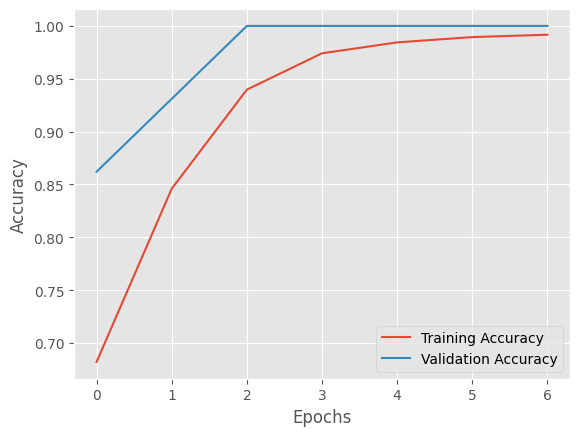

In [5]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()